*First compiled on May 25, 2017.*

### Lineage tree for adult hematopoiesis in mouse [(Nestorowa *et al.*, 2016)](https://doi.org/10.1182/blood-2016-05-716480)

In [13]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 3                # increase for more output
sc.settings.set_dpi(60)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+14.gdc3fb50.dirty on 2017-09-15 14:46.


In [5]:
cell_types = {
    'start_cells': '0Stem',  # stem cell / progenitor
    'C1': '1Ery',
    'C2': '2Mk',             # megakaryotic
    'C3' : '3',
    'C4': '4Baso',           # mast cell/basophil
    'C5': '5Neu',            # monocyte / granulocyte ?
    'C6': '6',
    'C7': '7Mo',             # granulocyte / monocyte ?
    'C8': '8Lymph',          # lymphoid
    'C9': '9',
    'C10': '10B'}            # B cells

def nestorowa16_raw():
    datadir = 'data/nestorowa16/data/'
    adata = sc.read(datadir + 'norm_counts_nestorowa_data.txt', cache=True)
    adata.smp_names = np.genfromtxt(datadir + 'cell_names_nestorowa_data.txt', dtype=str)
    adata.var_names = np.genfromtxt(datadir + 'gene_names_nestorowa_data.txt', dtype=str)
    exp_groups = np.genfromtxt(datadir + 'start_and_end_cells.txt', dtype=str)
    exp_groups = np.array([cell_types[n] if n in cell_types else n for n in exp_groups])                                                                                                                                       
    exp_groups[718] = 'no_gate'  # deal with one outlier in the C9 group
    adata.smp['exp_groups'] = exp_groups
    return adata

def nestorowa16():
    adata = nestorowa16_raw()    
    sc.pp.recipe_weinreb16(adata, svd_solver='arpack')
    adata.var['xroot'] = adata.X[np.flatnonzero(adata.smp['exp_groups'] == '0Stem')[0]]
    return adata
                                 
def nestorowa16_tf():
    """Filtered for transcription factors."""
    adata = nestorowa16_raw()
    tf_genes = np.genfromtxt('data/nestorowa16/data/tf_gene_list.txt', dtype=str)
    tf_gene_filter = np.in1d(adata.var_names, tf_genes)
    adata = adata[:, tf_gene_filter]
    sc.pp.weinreb16(adata, svd_solver='arpack')
    adata.var['xroot'] = adata.X[np.flatnonzero(exp_groups == '0Stem')[0]]
    return adata

In [3]:
adata_raw = nestorowa16_raw()
sc.write('nestorowa16_raw', adata_raw)

reading file ./write/data/nestorowa16/data/norm_counts_nestorowa_data.h5
writing ./write/nestorowa16_raw.h5


reading file ./write/data/nestorowa16/data/norm_counts_nestorowa_data.h5
    using "X_pca" for building graph
    computing data graph with n_neighbors = 4 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9911447763  0.9895198941  0.9886388779  0.983188808
      0.9765303135  0.9730944037  0.9681537747  0.9666156173  0.962413609
      0.9549077153  0.945613265   0.9399017096  0.93359828    0.9317871332]
    finished (0:00:00.387) and added
    "X_diffmap", the diffmap coordinates (adata.smp),
    "diffmap_evals", the eigenvalues of the transition matrix (adata.add)


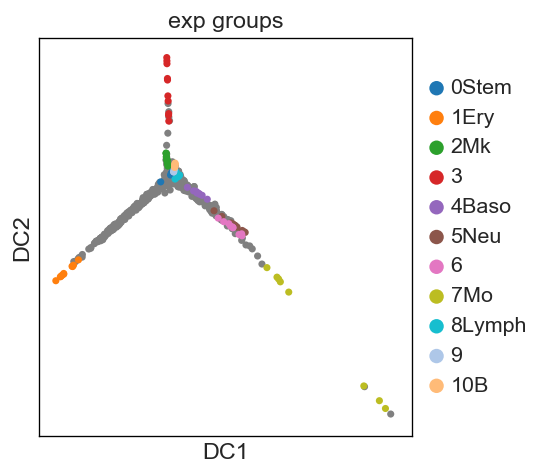

drawing single-cell graph using layout "fr"
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 4 and spectrum
    [ 1.            0.9911447763  0.9895198941  0.9886388779  0.983188808
      0.9765303135  0.9730944037  0.9681537747  0.9666156173  0.962413609
      0.9549077153  0.945613265   0.9399017096  0.93359828    0.9317871332]
    finished (0:00:17.478) and added
    "X_draw_graph_fr", graph_drawing coordinates (adata.smp)
    "draw_graph_layout", the chosen layout (adata.add)


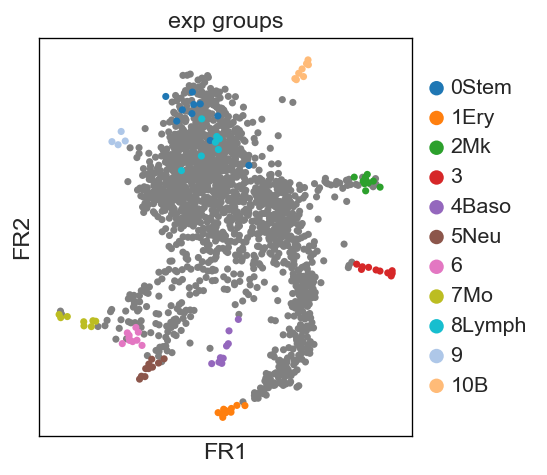

computing tSNE
    using X_pca for tSNE
    using 50 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:04.627) and added
    "X_tsne", tSNE coordinates (adata.smp)


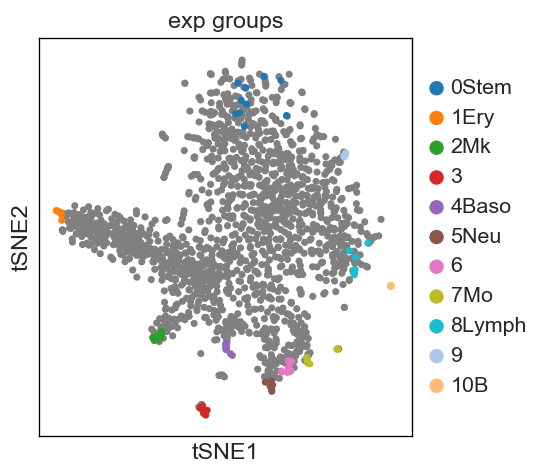

writing ./write/nestorowa16.h5


In [4]:
adata = nestorowa16()
sc.tl.diffmap(adata, n_neighbors=4)
ax = sc.pl.diffmap(adata, color='exp_groups')
sc.tl.draw_graph(adata, n_neighbors=4)
ax = sc.pl.draw_graph(adata, color='exp_groups')
sc.tl.tsne(adata)
ax = sc.pl.tsne(adata, color='exp_groups')
sc.write('nestorowa16', adata)

### Tree inference using graph abstraction

We use the same number of neighbors as for visualizing the data above and as in [*paul15](../paul15).

In [4]:
adata = sc.read('nestorowa16')
sc.tl.aga(adata, n_neighbors=4, resolution=1.3, tree_detection='greedy_extremes')
sc.write('nestorowa16', adata)

reading file ./write/nestorowa16.h5
running Approximate Graph Abstraction (AGA)
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 4 and spectrum
    [ 1.            0.9911447763  0.9895198941  0.9886388779  0.983188808
      0.9765303135  0.9730944037  0.9681537747  0.9666156173  0.962413609 ]
    abstracted graph will have 19 nodes
... finished (0:00:00.322) --> added
    aga_adjacency_full_attachedness : np.ndarray in adata.add
        The full adjacency matrix of the abstracted graph, weights
        correspond to attachedness.
    aga_adjacency_full_confidence : np.ndarray in adata.add
        The full adjacency matrix of the abstracted graph, weights
        correspond to confidence in the presence of an edge.
    aga_adjacency_tree_confidence : sparse csr matrix in adata.add
        The weighted adjacency matrix of the most probable tree in the
        abstracted graph.
    aga_groups : np.ndarray of dtype string in adata.smp
        Group labels

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 3                # increase for more output
sc.settings.set_dpi(60)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+14.gdc3fb50.dirty on 2017-09-15 14:49.


reading file ./write/nestorowa16.h5


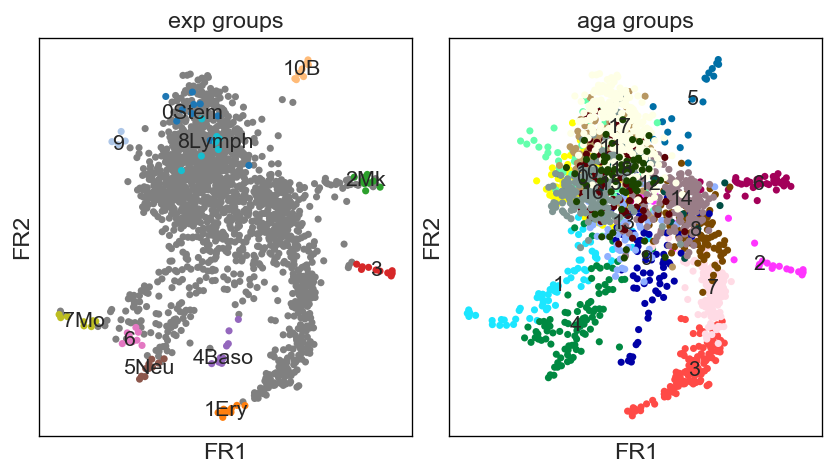

... you are using a very low resolution for saving figures, adjusting to dpi=300
... saving figure to file ./figures/draw_graph_fr.png


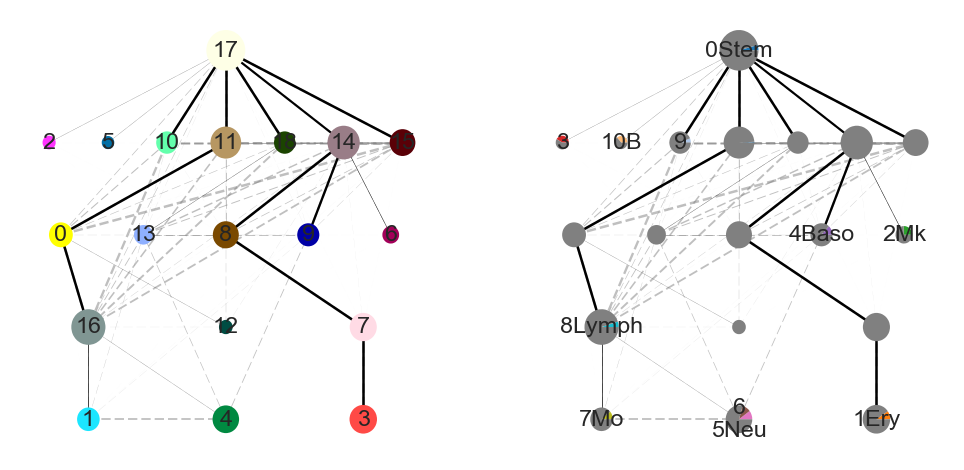

... saving figure to file ./figures/aga_graph.png


In [2]:
adata = sc.read('nestorowa16')
sc.pl.draw_graph(adata, color=['exp_groups', 'aga_groups'],
                 palette=[sc.pl.palettes.vega_20, sc.pl.palettes.godsnot_64],
                 legend_loc='on data', save=False, show=True)
rcParams['axes.titlesize'] = 13
sc.pl.draw_graph(adata, color=['exp_groups'],
                 title=['Nestorowa et al. (2016): s.-c. graph/ cell types'],
                 palette=[sc.pl.palettes.vega_20],
                 legend_loc='on data', save=True, show=False)
sc.pl.reset_rcParams()
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='aga_groups', reference='exp_groups',
    normalization='prediction')
asso_colors = sc.utils.get_associated_colors_of_groups(sc.pl.palettes.vega_20, asso_matrix)
root = 17
ax = sc.pl.aga_graph(adata,
                     root=root,
                     layout='eq_tree',
                     colors=[sc.pl.palettes.godsnot_64, asso_colors],
                     groups=['aga_groups', asso_names],
                     fontsize=14, show=True, save=False)
ax = sc.pl.aga_graph(adata,
                     root=root,
                     layout='eq_tree',
                     title=['Nestorowa et al. (2016): abs. graph/ cell types'],
                     colors=asso_colors,
                     groups=asso_names,
                     fontsize=14, show=False, save=True)

### Reconstruct dynamics for differentially expressed genes of leaf nodes

Some marker genes.

Erythroid - Gata1, Gypa, Hba-a2, Hba-a1   
Megakaryocyte - Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf   
'3' population - Ltf, Retnlg  
Basophils - Prss34, Ms4a2, Fcer1a, Siglecf   
Monocyte - Irf8, Csf1r, Ctsg, Mpo   
Neutrophils - Elane, Ctsg, Mpo, Gfi1   
Lymphoid - Dntt, Il7r, Rag2   
B cells - Cd19, Vpreb2, Cd79a   

In [6]:
adata_all_genes = nestorowa16_raw()
sc.pp.recipe_zheng17(adata_all_genes, n_top_genes=4000, plot=False)
adata_all_genes.smp['aga_groups'] = adata.smp['aga_groups']
adata_all_genes.smp['aga_pseudotime'] = adata.smp['aga_pseudotime']

reading file ./write/data/nestorowa16/data/norm_counts_nestorowa_data.h5
normalizing by total count per cell
    finished (0:00:00.050) normalized adata.X and added
    "n_counts_all", counts per cell before normalization (adata.smp)
filter highly varying genes by dispersion and mean (0:00:00.036)
normalizing by total count per cell
    finished (0:00:00.053) normalized adata.X and added
    "n_counts", counts per cell before normalization (adata.smp)


In [7]:
gene_names = ['Gata2', 'Gata1', 'Hba-a2', 'Gfi1', 'Elane', 'Irf8', 'Csf1r']

reading file ./write/nestorowa16.h5
... saving figure to file ./figures/aga_path_erythrocytes.png


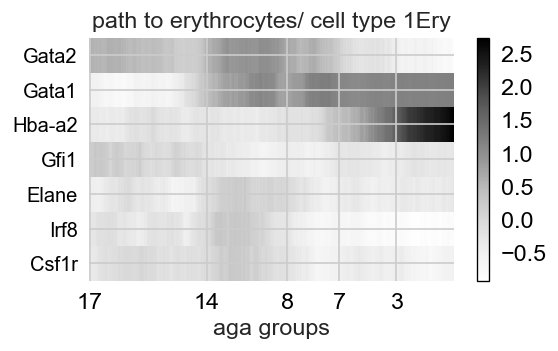

... saving figure to file ./figures/aga_path_neutrophils.png


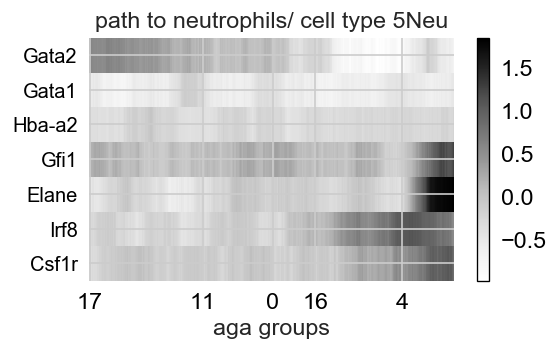

... saving figure to file ./figures/aga_path_monocytes.png


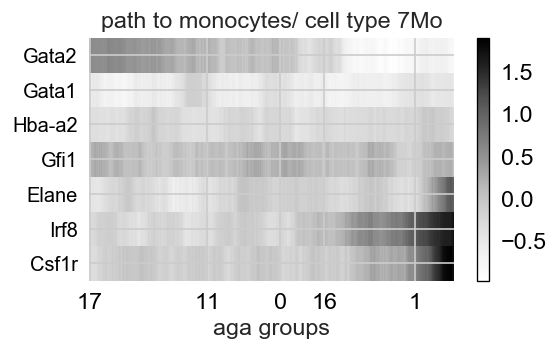

In [11]:
rcParams['figure.figsize'] = (5, 2.7)
rcParams['figure.subplot.top'] = 0.85
rcParams['figure.subplot.bottom'] = 0.1
adata = sc.read('nestorowa16')
paths = [('erythrocytes', [17, 14, 8, 7, 3]),
         ('neutrophils', [17, 11, 0, 16, 4]),
         ('monocytes', [17, 11, 0, 16, 1])]
cell_types = ['1Ery', '5Neu', '7Mo']
for ipath, (descr, path) in enumerate(paths):
    ax = sc.pl.aga_path(adata_all_genes,
                        nodes=path,
                        ytick_fontsize=12,
                        keys=gene_names,
                        n_avg=50,
                        title='path to ' + descr + '/ cell type {}'.format(cell_types[ipath]),
                        save='_' + descr, show=True)
sc.pl.reset_rcParams()